# LZPgen: Generation Probability from LZGraphs

**LZPgen** (Lempel-Ziv Generation Probability) is a metric that quantifies how likely a given sequence is to be generated by a repertoire's LZGraph model. It answers the question: *"How typical is this sequence for this repertoire?"*

This notebook covers:

1. **What is LZPgen?** &mdash; Definition and intuition
2. **Computing LZPgen for individual sequences** &mdash; `walk_probability` and `walk_log_probability`
3. **Monte Carlo LZPgen distribution** &mdash; `lzpgen_distribution()`
4. **Exact moments** &mdash; `lzpgen_moments()`
5. **Analytical distribution** &mdash; `lzpgen_analytical_distribution()` (Gaussian mixture + saddlepoint)
6. **Comparing repertoires via LZPgen** &mdash; `compare_lzpgen_distributions()`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['font.size'] = 11

from LZGraphs import (
    AAPLZGraph,
    LZPgenDistribution,
    compare_lzpgen_distributions,
)

/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data and Building the Graph

We use an amino-acid CDR3 repertoire (5,000 sequences) and build an **AAPLZGraph**.
The AAPLZGraph encodes each LZ sub-pattern together with its position, guaranteeing a DAG structure.

In [2]:
data = pd.read_csv('ExampleData3.csv', index_col=0)
print(f"Repertoire size: {len(data)} sequences")
data.head()

Repertoire size: 5000 sequences


,cdr3_amino_acid,V,J
12787,CASSGLAGSRSYNEQFF,TRBV2-1*01,TRBJ2-1*01
11502,CASSPTGGVYEQYF,TRBV19-1*01,TRBJ2-7*01
18830,CASSQTGESNQPQHF,TRBV6-5*01,TRBJ1-5*01
16109,CASSKTDISSPLHF,TRBV19-1*01,TRBJ1-6*01
19101,CASSLAGHSGGAQRGNEQFF,TRBV5-1*01,TRBJ2-1*01


In [3]:
graph = AAPLZGraph(data)
print(f"Nodes: {len(graph.nodes)}, Edges: {len(graph.edges)}")

Nodes: 1692, Edges: 9528


---
## 1. What is LZPgen?

An LZGraph is a **generative model**: it encodes the transition probabilities between LZ sub-patterns learned from the repertoire. Given a sequence $s$ decomposed into a walk $(v_0, v_1, \ldots, v_k)$ on the graph, its **generation probability** is:

$$
P(s) \;=\; P(v_0) \;\times\; \prod_{i=1}^{k} P(v_i \mid v_{i-1}) \;\times\; P(\text{stop} \mid v_k)
$$

where:
- $P(v_0)$ is the **initial state probability** &mdash; how likely a sequence starts with this sub-pattern
- $P(v_i \mid v_{i-1})$ are **edge transition probabilities** &mdash; the conditional probability of each step
- $P(\text{stop} \mid v_k)$ is the **stop probability** at the final node &mdash; estimated via MLE as $T(v_k) / (T(v_k) + f(v_k))$

Because these probabilities are typically very small, we work with **log-probabilities**:

$$
\log P(s) \;=\; \log P(v_0) + \sum_{i=1}^{k} \log P(v_i \mid v_{i-1}) + \log P(\text{stop} \mid v_k)
$$

This is the **LZPgen** value: a single number summarizing how typical or rare a sequence is under the repertoire model.

---
## 2. Computing LZPgen for Individual Sequences

To compute LZPgen for a specific sequence, first encode it into a graph walk, then call `walk_probability` or `walk_log_probability`.

In [4]:
# Pick a sequence from the repertoire
sequence = data['cdr3_amino_acid'].iloc[0]
print(f"Sequence: {sequence}")

# Encode it into graph nodes (the walk)
walk = AAPLZGraph.encode_sequence(sequence)
print(f"Walk:     {walk}")

# Compute the generation probability
pgen = graph.walk_probability(walk, verbose=False)
log_pgen = graph.walk_log_probability(walk, verbose=False)

print(f"\nP(seq)       = {pgen:.6e}")
print(f"log P(seq)   = {log_pgen:.4f}")

Sequence: CASSGLAGSRSYNEQFF
Walk:     ['C_1', 'A_2', 'S_3', 'SG_5', 'L_6', 'AG_8', 'SR_10', 'SY_12', 'N_13', 'E_14', 'Q_15', 'F_16', 'F_17']

P(seq)       = 4.364619e-10
log P(seq)   = -21.5523


The log-probability is a large negative number because it's the product of many small transition probabilities. More negative = rarer sequence.

In [5]:
# Let's break down the LZPgen calculation step by step
print("Step-by-step LZPgen breakdown:")
print("=" * 55)

# Initial state probability
init_prob = graph.initial_states_probability[walk[0]]
running_log_p = np.log(init_prob)
print(f"Initial state: {walk[0]}")
print(f"  P(init)     = {init_prob:.6f}")
print(f"  log P(init) = {running_log_p:.4f}")
print()

# Edge transitions
for i in range(len(walk) - 1):
    u, v = walk[i], walk[i + 1]
    w = graph.graph[u][v]['data'].weight
    running_log_p += np.log(w)
    print(f"Edge {u} -> {v}:  P = {w:.6f}  (cumulative log P = {running_log_p:.4f})")

# Terminal factor
last = walk[-1]
stop_p = graph.terminal_state_data.loc[last, 'wsif/sep']
running_log_p += np.log(stop_p)
print(f"\nStop at {last}:  P(stop) = {stop_p:.6f}")
print(f"Final log P(seq) = {running_log_p:.4f}")
print(f"Matches walk_log_probability: {abs(running_log_p - log_pgen) < 1e-10}")

Step-by-step LZPgen breakdown:
Initial state: C_1
  P(init)     = 1.000000
  log P(init) = 0.0000

Edge C_1 -> A_2:  P = 0.969376  (cumulative log P = -0.0311)
Edge A_2 -> S_3:  P = 0.888981  (cumulative log P = -0.1488)
Edge S_3 -> SG_5:  P = 0.020176  (cumulative log P = -4.0520)
Edge SG_5 -> L_6:  P = 0.022472  (cumulative log P = -7.8475)
Edge L_6 -> AG_8:  P = 0.090047  (cumulative log P = -10.2549)
Edge AG_8 -> SR_10:  P = 0.010000  (cumulative log P = -14.8601)
Edge SR_10 -> SY_12:  P = 0.111111  (cumulative log P = -17.0573)
Edge SY_12 -> N_13:  P = 0.236842  (cumulative log P = -18.4977)
Edge N_13 -> E_14:  P = 0.373333  (cumulative log P = -19.4830)
Edge E_14 -> Q_15:  P = 0.493976  (cumulative log P = -20.1882)
Edge Q_15 -> F_16:  P = 0.292135  (cumulative log P = -21.4188)
Edge F_16 -> F_17:  P = 1.000000  (cumulative log P = -21.4188)

Stop at F_17:  P(stop) = 0.875000
Final log P(seq) = -21.5523
Matches walk_log_probability: True


### Computing LZPgen for many sequences

You can compute LZPgen for every sequence in your repertoire to see the overall distribution:

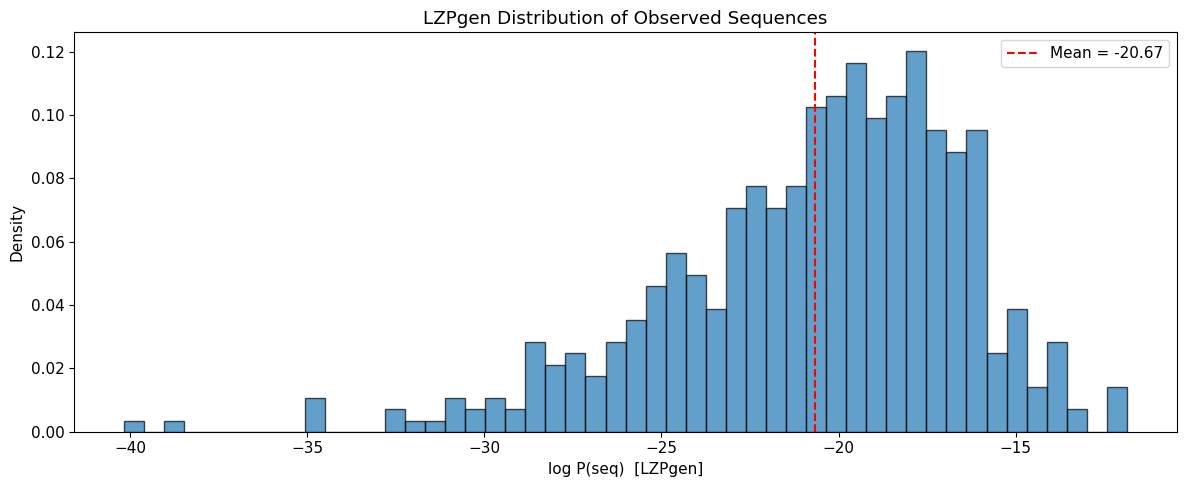

Mean log P(seq): -20.6675
Std  log P(seq): 4.1843


In [6]:
# Compute LZPgen for the first 500 sequences
log_pgens = []
for seq in data['cdr3_amino_acid'].iloc[:500]:
    walk = AAPLZGraph.encode_sequence(seq)
    lp = graph.walk_log_probability(walk, verbose=False)
    log_pgens.append(lp)

log_pgens = np.array(log_pgens)

plt.hist(log_pgens, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('log P(seq)  [LZPgen]')
plt.ylabel('Density')
plt.title('LZPgen Distribution of Observed Sequences')
plt.axvline(log_pgens.mean(), color='red', linestyle='--',
            label=f'Mean = {log_pgens.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean log P(seq): {log_pgens.mean():.4f}")
print(f"Std  log P(seq): {log_pgens.std():.4f}")

---
## 3. Monte Carlo LZPgen Distribution

The histogram above shows LZPgen for *observed* sequences. But what does the graph's **generative model** produce as a whole?

The `lzpgen_distribution()` method answers this by generating random walks from the graph and computing their log-probabilities. This gives the **model-implied** distribution of LZPgen &mdash; the probability distribution over all possible sequences the graph can generate.

This is a Monte Carlo approach: the more samples, the more accurate the estimate.

In [7]:
# Generate 50,000 random walks and compute their log-probabilities
mc_dist = graph.lzpgen_distribution(n=50_000, seed=42)

print(f"Shape: {mc_dist.shape}")
print(f"Mean:  {mc_dist.mean():.4f}")
print(f"Std:   {mc_dist.std():.4f}")
print(f"Min:   {mc_dist.min():.4f}")
print(f"Max:   {mc_dist.max():.4f}")

Shape: (50000,)
Mean:  -20.4454
Std:   3.9653
Min:   -42.6044
Max:   -9.5565


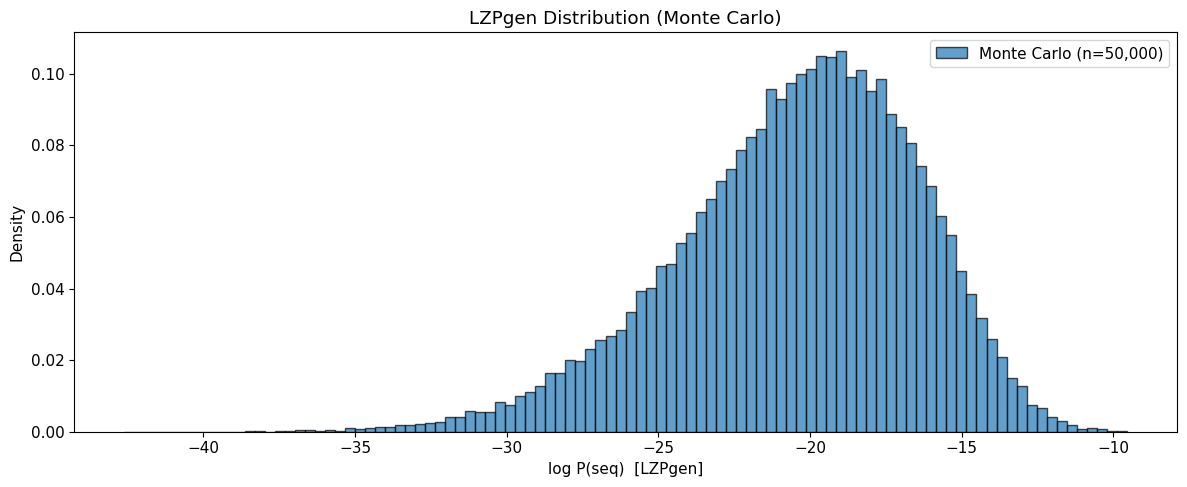

In [8]:
plt.hist(mc_dist, bins=100, density=True, alpha=0.7, edgecolor='black',
         label='Monte Carlo (n=50,000)')
plt.xlabel('log P(seq)  [LZPgen]')
plt.ylabel('Density')
plt.title('LZPgen Distribution (Monte Carlo)')
plt.legend()
plt.tight_layout()
plt.show()

---
## 4. Exact Moments via Forward Propagation

Monte Carlo sampling is straightforward but noisy. For DAG-structured graphs (AAPLZGraph, NDPLZGraph), we can compute the **exact** moments of the LZPgen distribution *deterministically* in a single pass through the graph.

The method `lzpgen_moments()` propagates probability mass and moment accumulators ($m_0$ through $m_4$) through the graph in topological order:

| Accumulator | Meaning |
|---|---|
| $m_0(v)$ | Total probability mass arriving at node $v$ |
| $m_1(v)$ | First moment: $\sum (\text{mass} \times \log P)$ |
| $m_2(v)$ | Second moment: $\sum (\text{mass} \times (\log P)^2)$ |
| $m_3(v)$ | Third moment (for skewness) |
| $m_4(v)$ | Fourth moment (for kurtosis) |

At each terminal node, the stopping mass contributes to the overall distribution. The result is **exact** &mdash; no sampling noise.

In [9]:
moments = graph.lzpgen_moments()

print("Exact LZPgen moments (forward propagation):")
print(f"  Mean       = {moments['mean']:.4f}")
print(f"  Variance   = {moments['variance']:.4f}")
print(f"  Std        = {moments['std']:.4f}")
print(f"  Skewness   = {moments['skewness']:.4f}")
print(f"  Kurtosis   = {moments['kurtosis']:.4f}")
print(f"  Total mass = {moments['total_mass']:.6f}  (should be ~1.0)")

Exact LZPgen moments (forward propagation):
  Mean       = -20.4206
  Variance   = 15.7082
  Std        = 3.9634
  Skewness   = -0.5689
  Kurtosis   = 0.3709
  Total mass = 1.000000  (should be ~1.0)


In [10]:
# Compare exact moments to Monte Carlo estimates
print("Exact vs Monte Carlo comparison:")
print(f"{'':>15s}  {'Exact':>10s}  {'MC (50K)':>10s}  {'Diff':>10s}")
print("-" * 50)
print(f"{'Mean':>15s}  {moments['mean']:>10.4f}  {mc_dist.mean():>10.4f}  {moments['mean'] - mc_dist.mean():>+10.4f}")
print(f"{'Std':>15s}  {moments['std']:>10.4f}  {mc_dist.std():>10.4f}  {moments['std'] - mc_dist.std():>+10.4f}")

Exact vs Monte Carlo comparison:
                      Exact    MC (50K)        Diff
--------------------------------------------------
           Mean    -20.4206    -20.4454     +0.0248
            Std      3.9634      3.9653     -0.0019


---
## 5. Analytical LZPgen Distribution

Beyond point estimates (mean, variance), we often need the **full distribution** &mdash; for plotting PDFs, computing quantiles, constructing confidence intervals, or running statistical tests. Monte Carlo can do this but requires many samples.

The `lzpgen_analytical_distribution()` method derives a **closed-form approximation** of the LZPgen distribution directly from graph structure, with no sampling. It combines two techniques:

### Length-Conditional Gaussian Mixture

Walks of the same length $k$ share similar structure. By the Central Limit Theorem, conditioned on walk length, the sum of log-transition-probabilities is approximately Normal:

$$
\log P(s) \mid \text{len}(s)=k \;\approx\; \mathcal{N}(\mu_k, \sigma_k^2)
$$

The overall LZPgen distribution is then a **finite Gaussian mixture** &mdash; one component per walk length:

$$
f(x) = \sum_k \pi_k \;\mathcal{N}(x; \mu_k, \sigma_k^2)
$$

where $\pi_k$ is the probability mass of walks with $k$ edges. All parameters $(\pi_k, \mu_k, \sigma_k)$ are computed by **length-stratified forward propagation** in $O(|E| \times K_{\max})$ time.

### Saddlepoint Approximation

Using the first four exact cumulants ($\kappa_1 \ldots \kappa_4$), a **saddlepoint approximation** provides an alternative density/CDF estimate that captures skewness and kurtosis. The Lugannani-Rice formula gives particularly accurate tail probabilities.

The result is an `LZPgenDistribution` object with a scipy-like interface.

In [11]:
dist = graph.lzpgen_analytical_distribution()
print(dist.summary())

LZPgenDistribution  (9 components)
  Mean     = -20.4206
  Std      = 3.9634
  Skewness = -0.5689
  Kurtosis = 0.3709
  95% CI   = (-28.72, -13.08)

  Components:
      k=6  weight=0.0022  mean=-16.4898  std=2.6545
      k=7  weight=0.1110  mean=-18.1168  std=3.1567
      k=8  weight=0.6220  mean=-19.6884  std=3.4554
      k=9  weight=0.1950  mean=-22.3572  std=3.7314
      k=10  weight=0.0454  mean=-24.8371  std=3.8627
      k=11  weight=0.0172  mean=-26.1482  std=3.8812
      k=12  weight=0.0054  mean=-26.7197  std=3.8809
      k=13  weight=0.0010  mean=-25.1423  std=4.0904
      k=14  weight=0.0008  mean=-26.0043  std=3.7779


### PDF: Probability Density Function

We can evaluate the PDF at any point and overlay it on the Monte Carlo histogram.

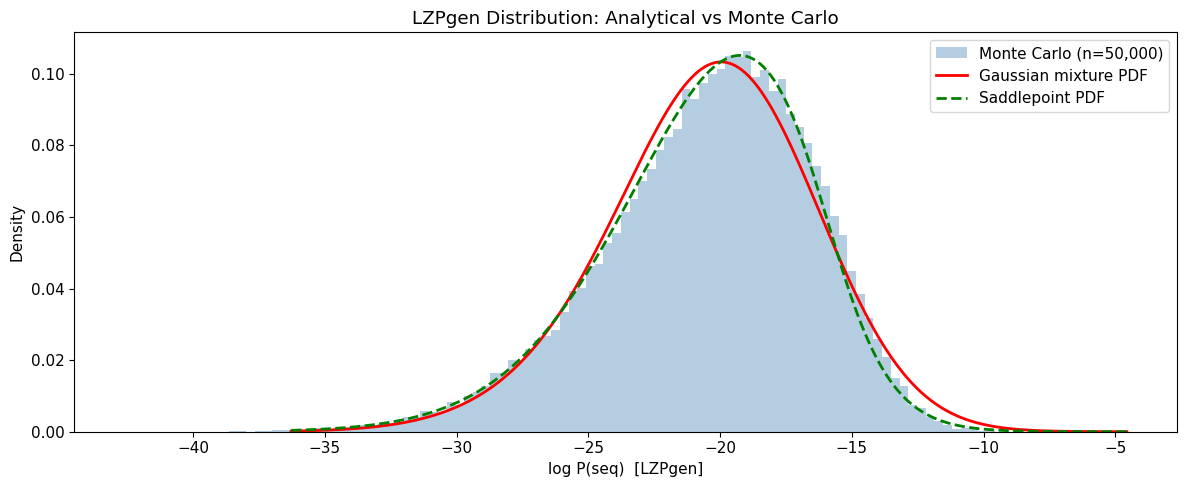

In [12]:
x = np.linspace(dist.mean() - 4 * dist.std(),
                dist.mean() + 4 * dist.std(), 500)

fig, ax = plt.subplots()
ax.hist(mc_dist, bins=100, density=True, alpha=0.4, color='steelblue',
        label='Monte Carlo (n=50,000)')
ax.plot(x, dist.pdf(x), 'r-', lw=2, label='Gaussian mixture PDF')
ax.plot(x, dist.saddlepoint_pdf(x), 'g--', lw=2, label='Saddlepoint PDF')
ax.set_xlabel('log P(seq)  [LZPgen]')
ax.set_ylabel('Density')
ax.set_title('LZPgen Distribution: Analytical vs Monte Carlo')
ax.legend()
plt.tight_layout()
plt.show()

### CDF: Cumulative Distribution Function

The CDF tells us *what fraction of sequences have LZPgen below a given threshold*.

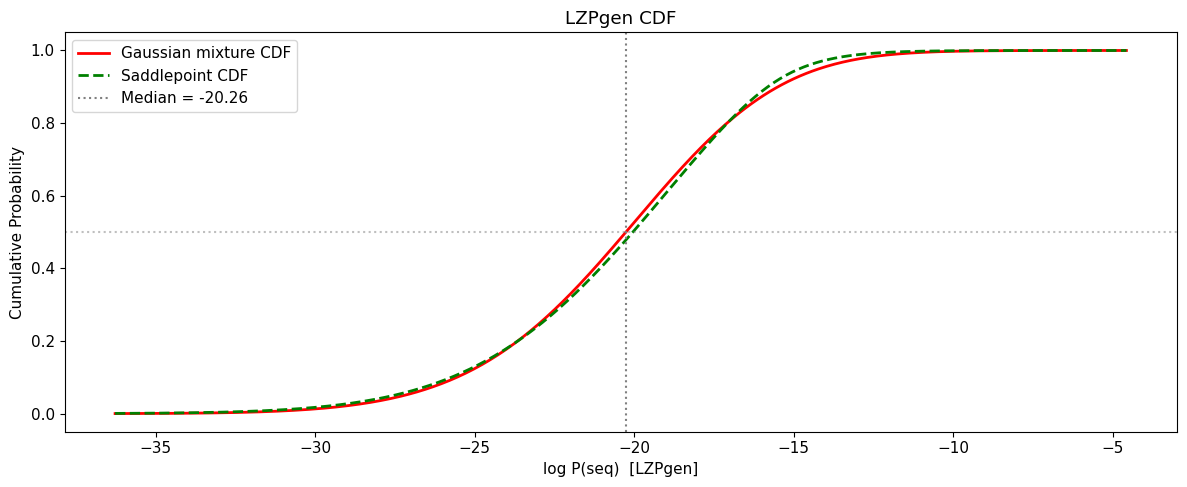

In [13]:
fig, ax = plt.subplots()
ax.plot(x, dist.cdf(x), 'r-', lw=2, label='Gaussian mixture CDF')
ax.plot(x, dist.saddlepoint_cdf(x), 'g--', lw=2, label='Saddlepoint CDF')

# Mark the median
median = dist.ppf(0.5)
ax.axvline(median, color='gray', linestyle=':', label=f'Median = {median:.2f}')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('log P(seq)  [LZPgen]')
ax.set_ylabel('Cumulative Probability')
ax.set_title('LZPgen CDF')
ax.legend()
plt.tight_layout()
plt.show()

### Quantiles and Confidence Intervals

The `ppf()` (percent-point function) gives quantiles, and `confidence_interval()` returns symmetric intervals.

In [14]:
print("Quantiles:")
for q in [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]:
    print(f"  {q:>5.0%}:  {dist.ppf(q):.4f}")

print()
lo, hi = dist.confidence_interval(0.05)
print(f"95% Confidence Interval: ({lo:.2f}, {hi:.2f})")

lo90, hi90 = dist.confidence_interval(0.10)
print(f"90% Confidence Interval: ({lo90:.2f}, {hi90:.2f})")

Quantiles:
     1%:  -30.4925
     5%:  -27.2221
    10%:  -25.5619
    25%:  -22.9535
    50%:  -20.2584
    75%:  -17.7075
    90%:  -15.4925
    95%:  -14.1929
    99%:  -11.7927

95% Confidence Interval: (-28.72, -13.08)
90% Confidence Interval: (-27.22, -14.19)


### Scoring Individual Sequences Against the Distribution

With the analytical distribution, you can compute the **percentile** of any sequence's LZPgen value, telling you where it falls in the repertoire's probability landscape.

In [15]:
# Score a few sequences
print(f"{'Sequence':<25s}  {'log P':>8s}  {'Percentile':>10s}")
print("-" * 50)

for seq in data['cdr3_amino_acid'].iloc[:8]:
    walk = AAPLZGraph.encode_sequence(seq)
    lp = graph.walk_log_probability(walk, verbose=False)
    percentile = dist.cdf(lp) * 100
    print(f"{seq:<25s}  {lp:>8.2f}  {percentile:>9.1f}%")

Sequence                      log P  Percentile
--------------------------------------------------
CASSGLAGSRSYNEQFF            -21.55       37.1%
CASSPTGGVYEQYF               -16.17       86.3%
CASSQTGESNQPQHF              -16.73       82.6%
CASSKTDISSPLHF               -27.24        5.0%
CASSLAGHSGGAQRGNEQFF         -21.38       38.7%
CASSPQDRPNYGYTF              -21.01       42.4%
CASSSQDRVTQYF                -19.03       62.6%
CASSSSGGATEQYF               -16.75       82.5%


### Random Sampling from the Analytical Distribution

The `rvs()` method draws random variates from the Gaussian mixture, useful for generating synthetic LZPgen values.

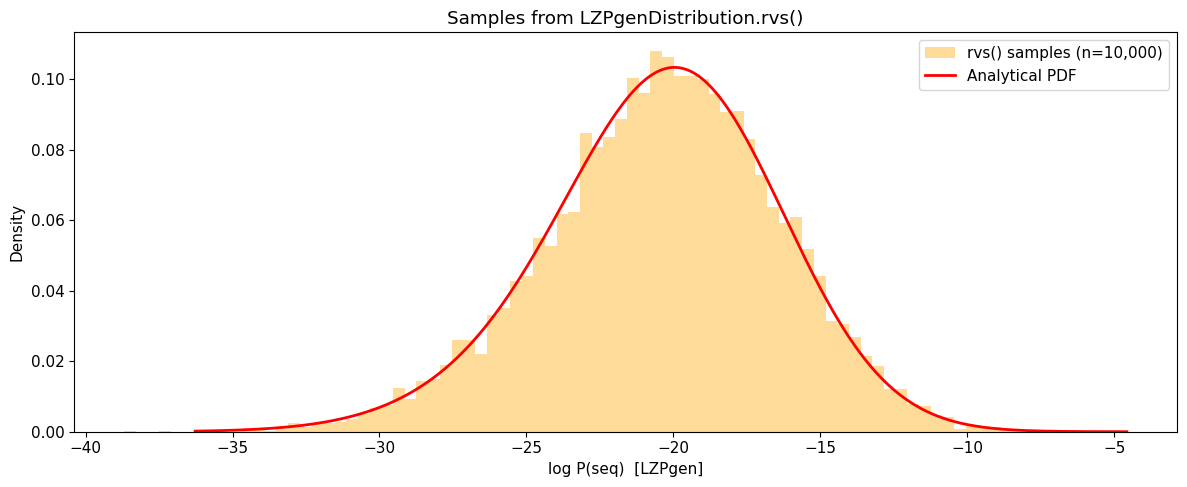

In [16]:
samples = dist.rvs(size=10_000, seed=42)

fig, ax = plt.subplots()
ax.hist(samples, bins=80, density=True, alpha=0.4, color='orange',
        label='rvs() samples (n=10,000)')
ax.plot(x, dist.pdf(x), 'r-', lw=2, label='Analytical PDF')
ax.set_xlabel('log P(seq)  [LZPgen]')
ax.set_ylabel('Density')
ax.set_title('Samples from LZPgenDistribution.rvs()')
ax.legend()
plt.tight_layout()
plt.show()

### Visualizing Mixture Components

Each component corresponds to walks of a specific length. We can visualize how different walk lengths contribute to the overall distribution.

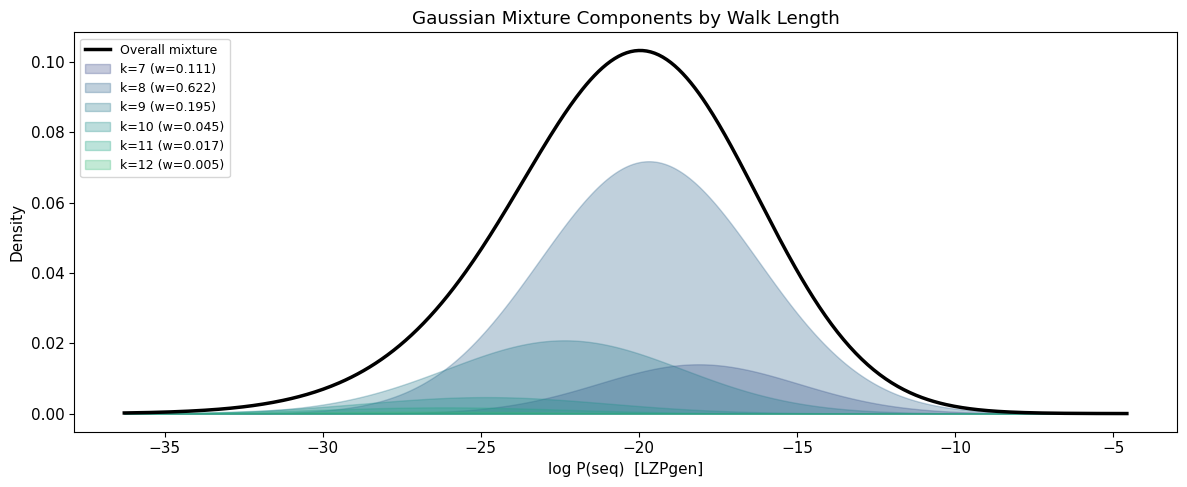

In [17]:
from scipy.stats import norm

fig, ax = plt.subplots()

# Plot overall PDF
ax.plot(x, dist.pdf(x), 'k-', lw=2.5, label='Overall mixture')

# Plot individual components
colors = plt.cm.viridis(np.linspace(0.15, 0.85, dist.n_components))
for i in range(dist.n_components):
    w, mu, sigma = dist.weights[i], dist.means[i], dist.stds[i]
    if w > 0.005:  # Only show components with >0.5% weight
        component_pdf = w * norm.pdf(x, mu, sigma) if sigma > 1e-15 else np.zeros_like(x)
        k = dist.walk_lengths[i] if dist.walk_lengths is not None else i
        ax.fill_between(x, component_pdf, alpha=0.3, color=colors[i],
                        label=f'k={k} (w={w:.3f})')

ax.set_xlabel('log P(seq)  [LZPgen]')
ax.set_ylabel('Density')
ax.set_title('Gaussian Mixture Components by Walk Length')
ax.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

---
## 6. Comparing Repertoires via LZPgen

A key application of LZPgen is **comparing repertoires**. If two repertoires have similar LZPgen distributions, they produce sequences with similar probabilities &mdash; they share similar generative structure.

### Using `compare_lzpgen_distributions()`

This function compares two empirical (Monte Carlo) distributions and returns:

| Metric | Description |
|--------|-------------|
| **ks_statistic** | Kolmogorov-Smirnov statistic (max CDF difference) |
| **ks_pvalue** | KS test p-value |
| **wasserstein** | Earth mover's distance |
| **jsd** | Jensen-Shannon divergence (base 2, bounded [0, 1]) |
| **mean_diff** | Difference in means |
| **std_ratio** | Ratio of standard deviations |
| **overlap_coefficient** | Density overlap (1 = identical, 0 = disjoint) |

Let's split our data into two halves and compare them.

In [18]:
# Split the data and build two graphs
data_a = data.iloc[:2500]
data_b = data.iloc[2500:]

graph_a = AAPLZGraph(data_a, verbose=False)
graph_b = AAPLZGraph(data_b, verbose=False)

print(f"Graph A: {len(graph_a.nodes)} nodes, {len(graph_a.edges)} edges")
print(f"Graph B: {len(graph_b.nodes)} nodes, {len(graph_b.edges)} edges")

Graph A: 1327 nodes, 6293 edges
Graph B: 1311 nodes, 6202 edges


In [19]:
# Monte Carlo distributions
dist_a = graph_a.lzpgen_distribution(n=50_000, seed=42)
dist_b = graph_b.lzpgen_distribution(n=50_000, seed=42)

# Compare
metrics = compare_lzpgen_distributions(dist_a, dist_b)

print("Comparison metrics (same donor, split halves):")
for key, val in metrics.items():
    print(f"  {key:<25s} = {val:.6f}")

Comparison metrics (same donor, split halves):
  ks_statistic              = 0.018460
  ks_pvalue                 = 0.000000
  wasserstein               = 0.160373
  jsd                       = 0.002020
  mean_diff                 = -0.160099
  std_ratio                 = 1.011493
  overlap_coefficient       = 0.966480


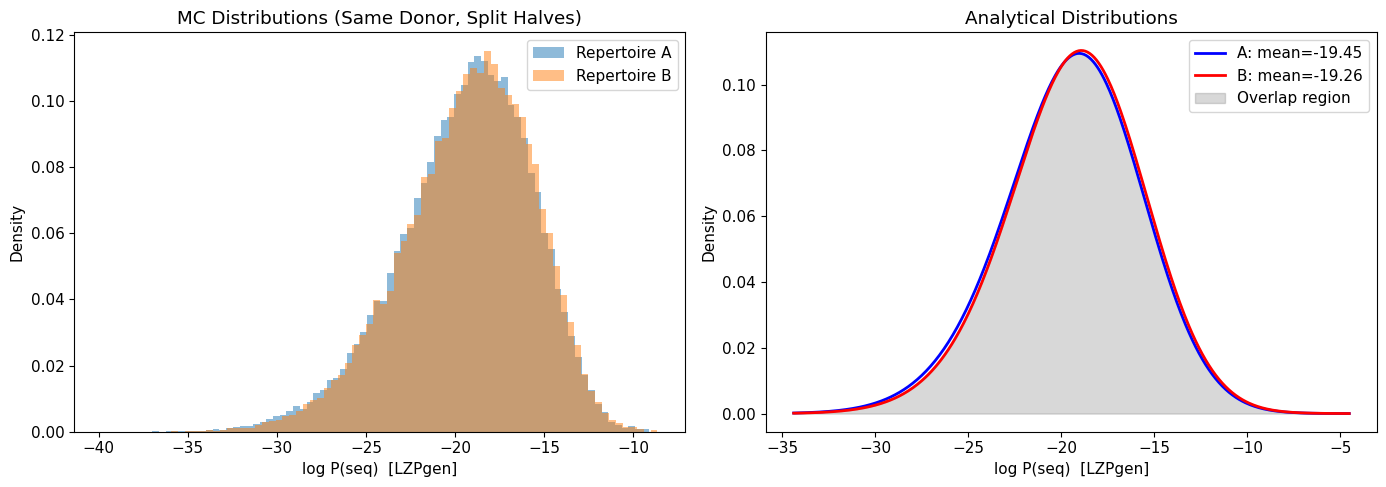

Analytical mean difference: -0.1895
Analytical std ratio:       1.0128


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overlaid histograms
axes[0].hist(dist_a, bins=80, density=True, alpha=0.5, label='Repertoire A')
axes[0].hist(dist_b, bins=80, density=True, alpha=0.5, label='Repertoire B')
axes[0].set_xlabel('log P(seq)  [LZPgen]')
axes[0].set_ylabel('Density')
axes[0].set_title('MC Distributions (Same Donor, Split Halves)')
axes[0].legend()

# Analytical distributions
ana_a = graph_a.lzpgen_analytical_distribution()
ana_b = graph_b.lzpgen_analytical_distribution()

lo = min(ana_a.mean() - 4*ana_a.std(), ana_b.mean() - 4*ana_b.std())
hi = max(ana_a.mean() + 4*ana_a.std(), ana_b.mean() + 4*ana_b.std())
x2 = np.linspace(lo, hi, 500)

axes[1].plot(x2, ana_a.pdf(x2), 'b-', lw=2, label=f'A: mean={ana_a.mean():.2f}')
axes[1].plot(x2, ana_b.pdf(x2), 'r-', lw=2, label=f'B: mean={ana_b.mean():.2f}')
axes[1].fill_between(x2, np.minimum(ana_a.pdf(x2), ana_b.pdf(x2)),
                     alpha=0.3, color='gray', label='Overlap region')
axes[1].set_xlabel('log P(seq)  [LZPgen]')
axes[1].set_ylabel('Density')
axes[1].set_title('Analytical Distributions')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Analytical mean difference: {ana_a.mean() - ana_b.mean():.4f}")
print(f"Analytical std ratio:       {ana_a.std() / ana_b.std():.4f}")

---
## Method Reference

| Method | Returns | Description |
|--------|---------|-------------|
| `walk_probability(walk)` | `float` | P(seq) for a single sequence |
| `walk_log_probability(walk)` | `float` | log P(seq) for a single sequence |
| `lzpgen_distribution(n, seed)` | `ndarray` | Monte Carlo log-prob samples |
| `lzpgen_moments()` | `dict` | Exact mean, variance, std, skewness, kurtosis |
| `lzpgen_analytical_distribution()` | `LZPgenDistribution` | Full analytical distribution |
| `compare_lzpgen_distributions(d1, d2)` | `dict` | KS, Wasserstein, JSD, overlap, etc. |

### `LZPgenDistribution` API

| Method | Description |
|--------|-------------|
| `pdf(x)` | Probability density (Gaussian mixture) |
| `cdf(x)` | Cumulative distribution function |
| `ppf(q)` | Quantile function (inverse CDF) |
| `rvs(size, seed)` | Random variates from the mixture |
| `saddlepoint_pdf(x)` | Saddlepoint density approximation |
| `saddlepoint_cdf(x)` | Lugannani-Rice CDF approximation |
| `mean()` / `var()` / `std()` | Central moments |
| `skewness()` / `kurtosis()` | Shape parameters (from exact cumulants) |
| `confidence_interval(alpha)` | Symmetric (alpha/2, 1-alpha/2) interval |
| `summary()` | Human-readable summary string |